In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [237]:
texts = load_files('data')
sample_length = 2500
def split_text(text, sample_length):
    samples = []
    i=0
    while i < len(text):
        while i > 0 and str(text[i]).isalpha():
            i+=1
            samples[len(samples)-1] += text[i]
        samples.append(text[i:i+sample_length+1])
        i += sample_length
    del samples[0]
    return samples
data = []
labels = []
author_labels = []
j = 0
for text in texts.data:
    new_records = split_text(text, sample_length)
    data += new_records
    for i in range(0,len(new_records)):
        labels.append(texts.target[j])
        author_labels.append(texts.target_names[texts.target[j]])
    j+=1
texts.data = data
texts.target = labels

In [6]:
# extract unigrams and bigrams
count_vect = TfidfVectorizer(decode_error='ignore', stop_words='english',lowercase=True, ngram_range=(1,2), min_df=0.001, max_df=0.1)
vector = count_vect.fit_transform(texts.data)

In [30]:
vector.shape

(8829, 23379)

In [21]:
df = pd.DataFrame(vector.todense(), columns=count_vect.get_feature_names())

In [238]:
msk = np.random.rand(len(df)) < 0.75
train_x = df[msk]
train_y = pd.Series(labels)[msk]
test_x = df[~msk]
test_y = pd.Series(labels)[~msk]
test_authors = pd.Series(author_labels)[~msk]
assert(len(train_x)==len(train_y))
assert(len(test_x)==len(test_y))

In [24]:
# Retain 90% of the variance
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9).fit(train_x)

In [243]:
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)
train_x_pca.shape

(6664, 3953)

In [28]:
import gc
gc.collect()

5759

In [245]:
selector = SelectKBest(f_classif, k=1000)
selector.fit_transform(train_x_pca, train_y)
selected_feature_ids = selector.get_support(indices=True)
train_x_reduced = train_x_pca[:,selected_feature_ids]
test_x_reduced = test_x_pca[:,selected_feature_ids]
assert(len(train_x_reduced)==len(train_y))
assert(len(test_x_reduced)==len(test_y))

In [27]:
from sklearn.metrics import precision_recall_fscore_support
def print_metrics(model):
    y_pred = model.predict(test_x_reduced)
    scores = precision_recall_fscore_support(test_y, y_pred, average='macro')
    print("Accuracy, Precision, Recall, F-score")
    print(str(round(model.score(test_x_reduced, test_y),3)) + "     " + str(round(scores[0],3))
         + "      " + str(round(scores[1],3)) + "    " + str(round(scores[2],3)))

In [64]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_x_reduced, train_y)
print_metrics(nb)

Accuracy, Precision, Recall, F-score
0.678     0.752      0.7    0.632


In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=150, solver='lbfgs', multi_class='multinomial')
lr.fit(train_x_reduced, train_y)
print_metrics(lr)

Accuracy, Precision, Recall, F-score
0.918     0.95      0.759    0.814


In [71]:
from sklearn.svm import LinearSVC
C = [0.2, 0.6, 1.0, 1.4, 1.8]
for c in C:
    linear_svc = LinearSVC(C=c)
    linear_svc.fit(train_x_reduced, train_y)
    print("C: " + str(c))
    print_metrics(linear_svc)

C: 0.2
Accuracy, Precision, Recall, F-score
0.937     0.957      0.854    0.896
C: 0.6
Accuracy, Precision, Recall, F-score
0.944     0.963      0.88    0.916
C: 1.0
Accuracy, Precision, Recall, F-score
0.947     0.97      0.888    0.924
C: 1.4
Accuracy, Precision, Recall, F-score
0.949     0.968      0.894    0.927
C: 1.8
Accuracy, Precision, Recall, F-score
0.949     0.968      0.895    0.927


In [40]:
lr.score(train_x_reduced, train_y)

0.9460269865067467

In [72]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=2500, max_depth=10)
rfc.fit(train_x_reduced, train_y)
print_metrics(rfc)

Accuracy, Precision, Recall, F-score
0.875     0.923      0.689    0.741


In [74]:
from sklearn.ensemble import RandomForestClassifier
trees = [100, 200, 300, 400]
for n in trees:
    print("N_trees: " + str(n))
    rfc = RandomForestClassifier(n_estimators=n)
    rfc.fit(train_x_reduced, train_y)
    print_metrics(rfc)

N_trees: 100
Accuracy, Precision, Recall, F-score
0.898     0.857      0.769    0.802
N_trees: 200
Accuracy, Precision, Recall, F-score
0.903     0.857      0.772    0.803
N_trees: 300
Accuracy, Precision, Recall, F-score
0.901     0.85      0.763    0.795
N_trees: 400
Accuracy, Precision, Recall, F-score
0.903     0.853      0.767    0.799


In [108]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [100, 200]
for n in estimators:
    print("N_estimators: " + str(n))
    print("Logistic Regression: ")
    ada = AdaBoostClassifier(LogisticRegression(max_iter=10, solver='lbfgs', multi_class='multinomial'), n_estimators=n)   
    ada.fit(train_x_reduced, train_y)
    print_metrics(ada)
    print("Decision Trees: ")
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=n)
    ada.fit(train_x_reduced, train_y)
    print_metrics(ada)

N_estimators: 100
Logistic Regression: 


/home/ewenw/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ewenw/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy, Precision, Recall, F-score
0.408     0.081      0.17    0.107
Decision Trees: 
Accuracy, Precision, Recall, F-score
0.495     0.582      0.361    0.383
N_estimators: 200
Logistic Regression: 


/home/ewenw/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ewenw/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy, Precision, Recall, F-score
0.432     0.457      0.182    0.126
Decision Trees: 
Accuracy, Precision, Recall, F-score
0.488     0.597      0.386    0.423


In [250]:
from keras.utils import to_categorical
one_hot_train_y = to_categorical(train_y, num_classes=11)
model = Sequential([
    Dense(1000, input_dim=1000),
    Dropout(0.25),
    Activation('relu'),
    Dense(100),
    Dropout(0.25),
    Activation('relu'),
    Dense(11),
    Activation('softmax'),
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_x_reduced, one_hot_train_y, epochs=40, batch_size=3000)

Epoch 1/40
6664/6664 [==============================] - 1s 183us/step - loss: 0.3015 - acc: 0.9091
Epoch 2/40
6664/6664 [==============================] - 1s 77us/step - loss: 0.2834 - acc: 0.9091
Epoch 3/40
6664/6664 [==============================] - 1s 109us/step - loss: 0.2629 - acc: 0.9091
Epoch 4/40
6664/6664 [==============================] - 1s 77us/step - loss: 0.2415 - acc: 0.9091
Epoch 5/40
6664/6664 [==============================] - 0s 73us/step - loss: 0.2186 - acc: 0.9116
Epoch 6/40
6664/6664 [==============================] - 0s 75us/step - loss: 0.1950 - acc: 0.9225
Epoch 7/40
6664/6664 [==============================] - 1s 76us/step - loss: 0.1713 - acc: 0.9345
Epoch 8/40
6664/6664 [==============================] - 1s 77us/step - loss: 0.1483 - acc: 0.9468
Epoch 9/40
6664/6664 [==============================] - 0s 73us/step - loss: 0.1289 - acc: 0.9589
Epoch 10/40
6664/6664 [==============================] - 0s 74us/step - loss: 0.1112 - acc: 0.9693
Epoch 11/40
6664/

In [251]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(test_x_reduced).argmax(axis=-1)
acc = accuracy_score(y_pred, test_y)
scores = precision_recall_fscore_support(test_y, y_pred, average='macro')
print("Accuracy, Precision, Recall, F-score")
print(str(round(acc,3)) + "     " + str(round(scores[0],3))
         + "      " + str(round(scores[1],3)) + "    " + str(round(scores[2],3)))

Accuracy, Precision, Recall, F-score
0.954     0.967      0.906    0.932


In [32]:
test_y[y_pred!=test_y].index

Int64Index([  51,   62,   63,  224,  229,  248,  251,  252,  436,  576,
            ...
            8155, 8156, 8511, 8514, 8599, 8627, 8747, 8751, 8816, 8824],
           dtype='int64', length=113)

In [33]:
texts.data[51]

b' and expenses, including\nlegal fees, and [2] YOU HAVE NO REMEDIES FOR NEGLIGENCE OR\nUNDER STRICT LIABILITY, OR FOR BREACH OF WARRANTY OR CONTRACT,\nINCLUDING BUT NOT LIMITED TO INDIRECT, CONSEQUENTIAL, PUNITIVE\nOR INCIDENTAL DAMAGES, EVEN IF YOU GIVE NOTICE OF THE\nPOSSIBILITY OF SUCH DAMAGES.\n\nIf you discover a Defect in this eBook within 90 days of\nreceiving it, you can receive a refund of the money (if any)\nyou paid for it by sending an explanatory note within that\ntime to the person you received it from. If you received it\non a physical medium, you must return it with your note, and\nsuch person may choose to alternatively give you a replacement\ncopy. If you received it electronically, such person may\nchoose to alternatively give you a second opportunity to\nreceive it electronically.\n\nTHIS EBOOK IS OTHERWISE PROVIDED TO YOU "AS-IS". NO OTHER\nWARRANTIES OF ANY KIND, EXPRESS OR IMPLIED, ARE MADE TO YOU AS\nTO THE EBOOK OR ANY MEDIUM IT MAY BE ON, INCLUDING BUT NOT\nL

In [36]:
texts.data[8824]

b'copy, display, perform, distribute or redistribute this\nelectronic work, or any part of this electronic work, without\nprominently displaying the sentence set forth in paragraph 1.E.1 with\nactive links or immediate access to the full terms of the Project\nGutenberg-tm License.\n\n1.E.6.  You may convert to and distribute this work in any binary,\ncompressed, marked up, nonproprietary or proprietary form, including any\nword processing or hypertext form.  However, if you provide access to or\ndistribute copies of a Project Gutenberg-tm work in a format other than\n"Plain Vanilla ASCII" or other format used in the official version\nposted on the official Project Gutenberg-tm web site (www.gutenberg.net),\nyou must, at no additional cost, fee or expense to the user, provide a\ncopy, a means of exporting a copy, or a means of obtaining a copy upon\nrequest, of the work in its original "Plain Vanilla ASCII" or other\nform.  Any alternate format must include the full Project Gutenberg-tm

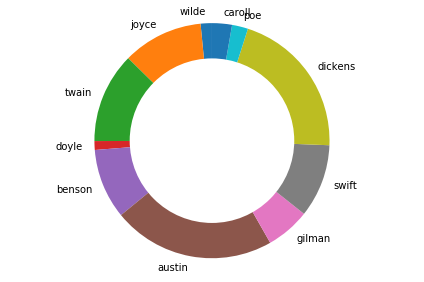

In [264]:
from collections import Counter
sizes = Counter(author_labels)
counts = list(sizes.values())
titles = list(sizes.keys())
fig1, ax1 = plt.subplots()
colors = ['#37AB65', '#3DF735', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#F6CC1D']
ax1.pie(counts, labels=titles, startangle=90, colors=colors)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


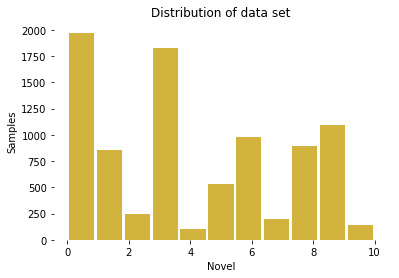

In [253]:
pd.Series(labels).plot.hist(grid=True, bins=11, rwidth=0.9,
                   color='#d1b33e')
plt.title('Distribution of data set')
plt.xlabel('Novel')
plt.ylabel('Samples')
plt.grid(axis='y', alpha=0.75)
plt.box(False)
plt.grid(False)

In [260]:
type(y_pred)
len(y_pred)
len(test_y)
list(test_authors[y_pred!=test_y])

['joyce',
 'joyce',
 'twain',
 'twain',
 'twain',
 'twain',
 'doyle',
 'benson',
 'benson',
 'benson',
 'austin',
 'austin',
 'gilman',
 'gilman',
 'gilman',
 'swift',
 'swift',
 'swift',
 'twain',
 'twain',
 'gilman',
 'gilman',
 'gilman',
 'austin',
 'austin',
 'benson',
 'doyle',
 'doyle',
 'gilman',
 'poe',
 'poe',
 'poe',
 'poe',
 'poe',
 'caroll',
 'caroll',
 'doyle',
 'doyle',
 'joyce',
 'joyce',
 'joyce',
 'joyce',
 'twain',
 'dickens',
 'dickens',
 'wilde',
 'joyce',
 'joyce',
 'joyce',
 'joyce',
 'joyce',
 'caroll',
 'gilman',
 'gilman',
 'twain',
 'twain',
 'twain',
 'twain',
 'dickens',
 'wilde',
 'austin',
 'doyle',
 'doyle',
 'doyle',
 'caroll',
 'caroll',
 'caroll',
 'swift',
 'swift',
 'swift',
 'swift',
 'austin',
 'swift',
 'dickens',
 'dickens',
 'austin',
 'austin',
 'joyce',
 'joyce',
 'dickens',
 'dickens',
 'dickens',
 'dickens',
 'benson',
 'benson',
 'benson',
 'poe',
 'wilde',
 'wilde',
 'wilde',
 'austin',
 'austin',
 'austin',
 'austin',
 'twain',
 'twain',


In [261]:
test_authors[y_pred!=test_y].plot.hist(grid=True, bins=11, rwidth=0.9,
                   color='#8c2a2a')
plt.title('Distribution of false predictions')
plt.xlabel('Novel')
plt.ylabel('Samples')
plt.box(False)
plt.grid(False)

TypeError: Empty 'DataFrame': no numeric data to plot

In [156]:
np.bincount(test_y[y_pred!=test_y])

array([11,  9, 13, 18,  7,  8, 11, 10,  9, 13,  7])

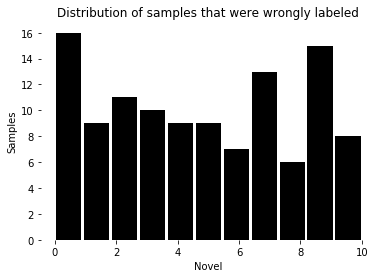

In [177]:
pd.Series(test_y[y_pred!=test_y]).plot.hist(grid=True, bins=11, rwidth=0.9,
                   color='#000000')
plt.title('Distribution of samples that were wrongly labeled')
plt.xlabel('Novel')
plt.ylabel('Samples')
plt.box(False)
plt.grid(False)

In [133]:
# Best features visualization
selector = SelectKBest(f_classif)
fit = selector.fit(df, labels)
indices = np.argsort(fit.scores_)[::-1]




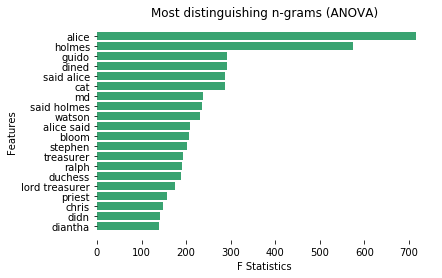

In [145]:
features = []
for i in range(20):
    features.append(df.columns[indices[i]])
plt.figure()
plt.barh(features, fit.scores_[indices[range(20)]], color='#39a371', align='center')
plt.title('Most distinguishing n-grams (ANOVA)')
plt.xlabel('F Statistics')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.box(False)
plt.grid(False)
plt.show()

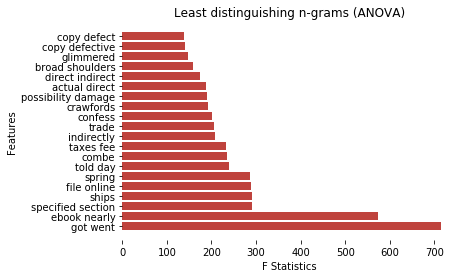

In [144]:
features = []
for i in range(20):
    features.append(df.columns[indices[len(df)-i]])
plt.figure()
plt.barh(features, fit.scores_[indices[range(20)]], color='#bf433d', align='center')
plt.title('Least distinguishing n-grams (ANOVA)')
plt.xlabel('F Statistics')
plt.ylabel('Features')
plt.gca()
plt.box(False)
plt.grid(False)
plt.show()

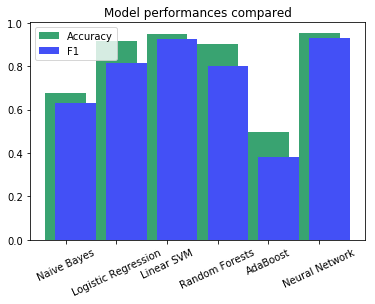

In [252]:
models = ["Naive Bayes", "Logistic Regression", "Linear SVM", "Random Forests", "AdaBoost (Decision Trees)", "Neural Network"]
accuracies = [0.678, 0.918, 0.949, 0.903, 0.495, 0.954]
f_scores = [0.632, 0.814, 0.927, 0.803, 0.383, 0.932]
fig, ax = plt.subplots()
indices = np.arange(len(accuracies))
width = 0.8
plt.bar(indices, accuracies, width=width, 
        color='#39a371', label='Accuracy')
plt.bar([i+0.25*width for i in indices], f_scores, 
        width=width, color='#4350f6', label='F1')

ax.set_xticklabels(("","Naive Bayes", "Logistic Regression", "Linear SVM", "Random Forests", "AdaBoost", "Neural Network"),rotation=25)
plt.title("Model performances compared")
plt.legend()
plt.show()